In [23]:
import re

import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [24]:
lobbyist_filename = '../../data/clean/misconduct_lobbying_indicators_train.pkl'
normal_filename = '../../data/clean/misconduct_indicators_train.pkl'

with open(lobbyist_filename, 'rb') as train_file:
    misconduct = pickle.load(train_file)

In [25]:
indicated_cols = [
    'misconduct_type',
    'court_type',
    'enforcement_agency',
    'contracting_party'
]

indicator_features = [
    col for col in misconduct.columns
    if re.search(f'^({"|".join(indicated_cols)})_', col)
]

features = indicator_features + [
    'lobbying_firms',
    'lobbyists',
    'has_lobbyist'
]

design_matrix = misconduct[[*features]]
design_matrix = pd.concat(
    [
        design_matrix,
        pd.get_dummies(
            misconduct['disposition_type'],
            prefix='disposition_type'
        )
    ],
    axis=1
)

In [26]:
sum(
    pd.isnull(misconduct['total_penalties']) |
    misconduct['total_penalties'] == 0.0
)

504

In [27]:
def cv_mean(model):
    return np.mean(
        cross_val_score(
            model,
            misconduct.loc[:, features],
            misconduct['disposition_type'],
            cv=3 # limited by class imbalance
        )
    )

In [28]:
model_cv_score = {}

In [7]:
# n_neighbors
#     accuracy peaked at ~10 and ~30
#     ~30 barely lower and less variance in region
# p not important because the features are binary
model_cv_score['knn'] = cv_mean(
    KNeighborsClassifier(p=1, weights='distance', n_neighbors=30)
)

In [8]:
model_cv_score['naive_bayes_bern'] = cv_mean(
    BernoulliNB()
)

In [9]:
model_cv_score['logistic_regression'] = cv_mean(
    LogisticRegression(solver='sag', multi_class='auto')
)

/Users/lu/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lu/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lu/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [10]:
model_cv_score['svc_linear'] = cv_mean(
    SVC(kernel='linear')
)

In [11]:
model_cv_score['svc_rbf'] = cv_mean(
    SVC(kernel='rbf', gamma='auto')
)

In [12]:
# model_cv_score['svc_poly'] = cv_mean(
#     SVC(kernel='poly', gamma='auto')
# )

In [13]:
# model_cv_score['svc_sigmoid'] = cv_mean(
#     SVC(kernel='sigmoid', gamma='auto')
# )

In [18]:
model_cv_score['lone_decision_tree'] = cv_mean(
    DecisionTreeClassifier()
)

In [19]:
model_cv_score['random_forest'] = cv_mean(
    RandomForestClassifier(
        n_estimators=76, # entropy more uniform, gini needed at least ~60
        max_depth=16, # too high? but cross validation works
        criterion='entropy', # mot much difference
        random_state=62
    )
)

In [30]:
# model_cv_score['cat_boost'] = cv_mean(
#     CatBoostClassifier(
#         iterations=2,
#         depth=2,
#         learning_rate=1,
#         loss_function='Logloss',
#         logging_level='Verbose'
#     )
# )


# model.fit(train_data, train_labels)
# # make the prediction using the resulting model
# preds_class = model.predict(test_data)
# preds_proba = model.predict_proba(test_data)

{'knn': 0.5440355479633409,
 'naive_bayes_bern': 0.5725154884564829,
 'logistic_regression': 0.541173101307476,
 'svc_linear': 0.6197508837364435,
 'svc_rbf': 0.5151050377920682,
 'lone_decision_tree': 0.5680404130143386,
 'random_forest': 0.6292074978070495}

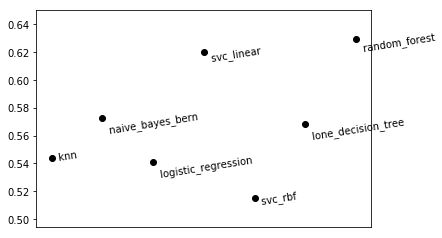

In [20]:
names = list(model_cv_score.keys())
scores = list(model_cv_score.values())

plt.scatter(
    names,
    scores,
    color='#000000'
)

plt.xticks([], rotation='vertical')
for ind, name in enumerate(names):
    plt.annotate(f'  {name}', (names[ind], scores[ind]), rotation=9)

model_cv_score

In [21]:
model_cv_score

{'knn': 0.5440355479633409,
 'naive_bayes_bern': 0.5725154884564829,
 'logistic_regression': 0.541173101307476,
 'svc_linear': 0.6197508837364435,
 'svc_rbf': 0.5151050377920682,
 'lone_decision_tree': 0.5680404130143386,
 'random_forest': 0.6292074978070495}